#Text based emotion Detector

In [1]:
# Import the required datasets
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [2]:
#Load the dataset - Contains 6 emotions
df = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
# Define Tokenizer - DistilBERT tokenizer converts text into input IDs and attention masks
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

#
def tokenize_text(texts, max_length=128):\
  '''
  Pads sequences to the same length, Truncates long sentences
  and converts them into tensors

  Returns:
   TensorFlow tensors for model compatibility
  '''
  return tokenizer(
      texts,
      padding=True,
      truncation=True,
      max_length=max_length,
      return_tensors='tf'
  )


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
# Prepare the data : tokenize training data and convert labels to tensorflow tensor
encoded_data = tokenize_text(list(df['train']['text']))
input_ids = encoded_data['input_ids']
attention_mask = encoded_data['attention_mask']
labels = tf.constant(list(df['train']['label']), dtype=tf.int32)

#Class_weights is used to handle the imbalence between the emotions, it penalize misclassification of minority classes more,forcing the model to learn them instead of ignoring them.
class_weights = {
    0: 0.8,   # sadness
    1: 0.8,   # joy
    2: 1.6,   # love
    3: 1.1,   # anger
    4: 1.2,   # fear
    5: 3.0    # surprise
}
print("Class weights:", class_weights)

#initilize pipelines
BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        },
        labels
    )
)
dataset = dataset.shuffle(10000)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

Class weights: {0: 0.8, 1: 0.8, 2: 1.6, 3: 1.1, 4: 1.2, 5: 3.0}


In [6]:
# Pre-load the trained DistilBERT BASE model
bert_model = TFAutoModel.from_pretrained("distilbert-base-uncased",
                                         use_safetensors=False,
                                         return_dict=False)

# Enabling fine tuning
bert_model.trainable = True

#Define the BertClassifier
class BertClassifier(tf.keras.Model):
    def __init__(self, bert_model, num_classes=6):
        super().__init__()
        self.bert = bert_model
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):
      #Passing input through bert classifier
        bert_outputs = self.bert(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            training=training
        )
        # DistilBERT does not have a 'pooler_output', so we use the first token of the last hidden state
        token_embeddings = bert_outputs[0]
        attention_mask = tf.cast(inputs["attention_mask"], tf.float32)

        mask = tf.expand_dims(attention_mask, axis=-1)
        masked_embeddings = token_embeddings * mask

        mean_pool = tf.reduce_sum(masked_embeddings, axis=1) / tf.reduce_sum(mask, axis=1)

        x = self.dropout(mean_pool, training=training)
        return self.classifier(x)



config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/363M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was

In [7]:
#Build the model
model = BertClassifier(bert_model)

#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
#Fit the model
history = model.fit(
    dataset,
    epochs=15,
    validation_data=dataset_val,
    class_weight=class_weights,
    callbacks = tf.keras.callbacks.EarlyStopping( #EarlyStopping prevents overfitting and restores best weights
        monitor="val_loss",
        patience=3,
        restore_best_weights=True)
)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - accuracy: 0.4269 - loss: 1.6181 - val_accuracy: 0.5385 - val_loss: 1.4234
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.4943 - loss: 1.5643 - val_accuracy: 0.5415 - val_loss: 1.3945
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - accuracy: 0.4992 - loss: 1.5748 - val_accuracy: 0.5470 - val_loss: 1.3774
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.5161 - loss: 1.5502 - val_accuracy: 0.5495 - val_loss: 1.3651
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 91ms/step - accuracy: 0.5171 - loss: 1.5328 - val_accuracy: 0.5540 - val_loss: 1.3509
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.5200 - loss: 1.5317 - val_accuracy: 0.5635 - val_loss: 1.3421
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.5164 - loss: 1.5258 - val_accuracy: 0.5660 - val_loss: 1.3299
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.5189 - loss: 1.5105 - 

DistilBERT Model saved successfully to distilbert_emotion_classifier.h5


# Evaluation Metrics
Confusion matrix shows class-wise prediction behavior

Classification report provides precision, recall, and F1-score


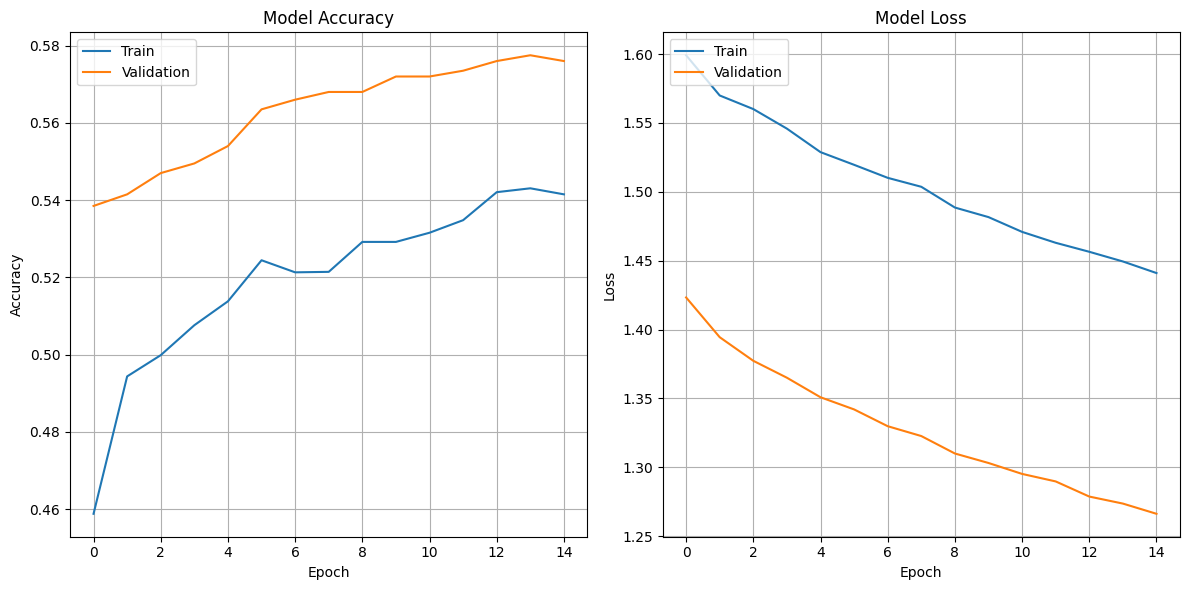

In [16]:
def plot_metrics(history):
    """
    Plots the training and validation accuracy and loss from a Keras history object.

    Args:
        history: A Keras history object returned from model.fit().
    """
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(history)

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer

all_true_labels_bert = []
all_predicted_probs_bert = []

for batch_inputs, batch_labels in dataset_val:
    all_true_labels_bert.append(batch_labels.numpy())
    all_predicted_probs_bert.append(model.predict(batch_inputs))

# Only proceed if 'model' was defined and predictions were made
if all_predicted_probs_bert:
    true_labels_bert = np.concatenate(all_true_labels_bert)
    predicted_probs_bert = np.concatenate(all_predicted_probs_bert)
    predicted_labels_bert = np.argmax(predicted_probs_bert, axis=1)

    print("\n--- Evaluation for DistilBERT Model ---\n")

    # 2. Generate and print the Confusion Matrix
    print("\n--- Confusion Matrix (DistilBERT) ---\n")
    conf_matrix_bert = confusion_matrix(true_labels_bert, predicted_labels_bert)
    print(conf_matrix_bert)

    # 3. Generate and print the Classification Report
    class_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    print("\n--- Classification Report (DistilBERT) ---\n")
    class_report_bert = classification_report(true_labels_bert, predicted_labels_bert, target_names=class_names)
    print(class_report_bert)

    # 4. Save the model
    model_save_path_bert = "distilbert_emotion_classifier.h5"
    model.save(model_save_path_bert)
    print(f"\nDistilBERT Model saved successfully to {model_save_path_bert}\n")

    encoded_data_test = tokenize_text(list(df['test']['text']))
    dataset_test = tf.data.Dataset.from_tensor_slices(
        (
            {
                "input_ids": encoded_data_test['input_ids'],
                "attention_mask": encoded_data_test['attention_mask'],
            },
            tf.constant(list(df['test']['label']))
        )
    ).batch(BATCH_SIZE)

    test_loss, test_acc = model.evaluate(dataset_test)
    print("Test Accuracy:", test_acc)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 


--- Evaluation for DistilBERT Model ---


--- Confusion Matrix (DistilBERT) ---

[[404  79   3  36  28   0]
 [ 85 568  13  11  21   6]
 [ 38  99  24   8   9   0]
 [130  42   4  71  24   4]
 [ 76  41   2  10  74   9]
 [ 19  35   1   5  10  11]]

--- Classification Report (DistilBERT) ---

              precision    recall  f1-score   support

     sadness       0.54      0.73      0.62       550
         joy       0.66      0.81      0.72       704
        love       0.51      0.13      0.21       178
       anger       0.50      0.26      0.34       275
        fear       0.45      0.35      0.39       212
    surprise       0.37      0.14      0.20        81

    accuracy                           0.58      2000
   macro avg       0.50      0.40      0.41      2000
weighted avg       0.56      0.58      0.54      2000


DistilBERT Model saved successfully to distilbert_emotion_classifier.h5

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5789 - loss: 1.2645
Test Accuracy: 0.57

In [18]:
def predict_emotion_bert(text_input):
    """
    Predicts the emotion of a given text input using the trained DistilBERT model.

    Args:
        text_input (str): The text string for which to predict the emotion.

    Returns:
        str: The predicted emotion label.
    """
    # Tokenize the input text
    encoded_input = tokenize_text([text_input])

    # Make prediction using the trained model
    # The model expects input_ids and attention_mask as a dictionary
    predictions = model.predict({
        "input_ids": encoded_input['input_ids'],
        "attention_mask": encoded_input['attention_mask']
    })

    # Get the predicted class index (index with the highest probability)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Map the index to the emotion label
    # Ensure class_names is available in the global scope or passed to the function
    # class_names was defined in a previous cell as: class_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    predicted_emotion = class_names[predicted_class_index]

    return predicted_emotion

print("The predict_emotion_bert function has been defined.")

The predict_emotion_bert function has been defined.


In [19]:
sample_text = "i am peaceful"
predicted_emotion = predict_emotion_bert(sample_text)
print(f"Sample Text: '{sample_text}'")
print(f"Predicted Emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Sample Text: 'i am peaceful'
Predicted Emotion: joy
